## 0. lstm Model
- 使用之前5天的数据，对之后48小时的空气质量进行预测，模型如下

![](http://p3rz3gu1u.bkt.clouddn.com/2018-04-14-lstm_predict_aq.png)
<caption><center> **Figure 1**: lstm model</center></caption>

In [1]:
# Using pandas to process data
import numpy as np
import pandas as pd
import tensorflow as tf
import datetime
import os
from matplotlib import pyplot as plt
%matplotlib inline
import keras.backend.tensorflow_backend as KTF

from utils.data_util import parse_bj_aq_data, generate_model_data
# from utils.plot_util import plot_station, plot_stations
from lstm.lstm_data_util import generate_test_samples, generate_data_for_lstm
from lstm.rnn_model import rnn_model, single_rnn_model
from metrics.metrics import SMAPE_on_dataset

/home/cvdev/tf/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

gpu_config = tf.ConfigProto()
gpu_config.gpu_options.allow_growth = True
session = tf.Session(config=gpu_config)
KTF.set_session(session)

In [3]:
bj_aq_data, stations, bj_aq_stations, bj_aq_stations_merged = parse_bj_aq_data()

NaN in PM2.5 is 23459, 6.508615 %
NaN in PM10 is 96175, 26.683406 %
NaN in NO2 is 21720, 6.026135 %
NaN in CO is 46144, 12.802486 %
NaN in O3 is 23732, 6.584358 %
NaN in SO2 is 21664, 6.010598 %
There are 35 air quality stations in Beijing

The stations in Beijing are:
 {'tiantan_aq', 'shunyi_aq', 'yanqin_aq', 'yungang_aq', 'huairou_aq', 'mentougou_aq', 'fengtaihuayuan_aq', 'daxing_aq', 'dingling_aq', 'dongsihuan_aq', 'pinggu_aq', 'tongzhou_aq', 'donggaocun_aq', 'miyunshuiku_aq', 'aotizhongxin_aq', 'qianmen_aq', 'yongledian_aq', 'pingchang_aq', 'nongzhanguan_aq', 'guanyuan_aq', 'wanliu_aq', 'dongsi_aq', 'fangshan_aq', 'gucheng_aq', 'yizhuang_aq', 'miyun_aq', 'badaling_aq', 'yongdingmennei_aq', 'zhiwuyuan_aq', 'liulihe_aq', 'nansanhuan_aq', 'yufa_aq', 'beibuxinqu_aq', 'xizhimenbei_aq', 'wanshouxigong_aq'}


/home/cvdev/air-quality-prediction/utils/data_util.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  bj_aq_station.drop("utc_time", axis=1, inplace=True)
/home/cvdev/air-quality-prediction/utils/data_util.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  bj_aq_station.drop("stationId", axis=1, inplace=True)


In [4]:
# take some data for example
ts = bj_aq_stations_merged["tongzhou_aq_PM2.5"]

## 1 单变量预测
- 单变量预测，用来验证模型在简单情况下的有效性
- 向前预测一步时预测效果较好，当预测更远的数据时，效果迅速变差

#### 1.1 向前预测一步

In [5]:
# 单一变量的情况下，使用长度为30的序列，向前预测一位
num_periods = 30
f_horizon = 1

In [6]:
X_batches, y_batches, X_test, y_test = generate_data_for_lstm(ts, num_periods = num_periods, f_horizon = f_horizon)

length of training data x :  (10290,)
length of training data y :  (10290,)
training data x shape :  (343, 30, 1)
test data x shape :  (1, 30, 1)


In [7]:
X_test.shape

(1, 30, 1)

0   MSE: 148284750.0
1000   MSE: 1954402.8
2000   MSE: 1657395.6
3000   MSE: 1535317.9
4000   MSE: 1418468.6


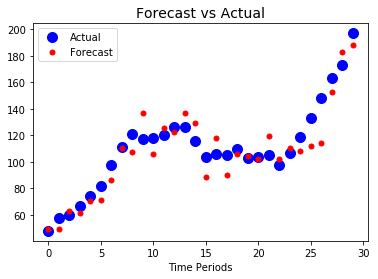

In [8]:
losses, Y_pred = single_rnn_model(X_batches, y_batches, X_test, y_test, cell="BasicRNNCell", 
                  learning_rate=0.001, epochs=5000, print_every=1000, 
                  inputs=1, outputs=1, hidden=100, num_periods=num_periods)

#### 1.2 向前预测多步

In [12]:
def moving_f_horizons(ts, f_horizons, num_periods):
    '''
    Check the relationship between f_horizon, num_periods against the behavior.
    Parameters must match.
    
    Argus:
        ts : time series to be used.
        f_horizons : how many steps predicting.
        num_periods : total length of Tx.
    '''
    y_tests = []
    y_preds = []
    Losses = []
    for f_horizon in f_horizons:    
        X_batches, y_batches, X_test, y_test = generate_data_for_lstm(ts, num_periods = num_periods, f_horizon = f_horizon)
        print(X_test.shape)
        print("f_horizon is %d." %f_horizon)
        losses, y_pred = single_rnn_model(X_batches, y_batches, X_test, y_test, cell="BasicRNNCell", 
                  learning_rate=0.001, epochs=2000, print_every=1000, 
                  inputs=1, outputs=1, hidden=100, num_periods=num_periods)
        y_tests.append(y_test)
        y_preds.append(y_pred)
        Losses.append(losses)
        
    return Losses, y_tests, y_preds

length of training data x :  (10248,)
length of training data y :  (10248,)
training data x shape :  (61, 168, 1)
test data x shape :  (1, 168, 1)
(1, 168, 1)
f_horizon is 2.
0   MSE: 82810310.0
1000   MSE: 5613722.0
length of training data x :  (10248,)
length of training data y :  (10248,)
training data x shape :  (61, 168, 1)
test data x shape :  (1, 168, 1)
(1, 168, 1)
f_horizon is 5.
0   MSE: 97442040.0
1000   MSE: 14070468.0


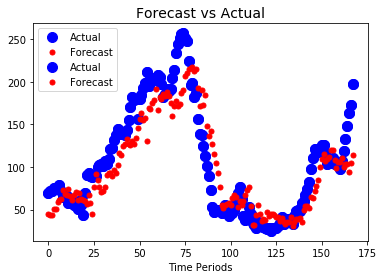

In [13]:
# num_periods=168 相当于一周七天的时间
# f_horizons = 48 相当于预测两天的时间
f_horizons = [2,5]
num_periods = 168

Losses, y_tests, y_preds = moving_f_horizons(ts, f_horizons, num_periods)

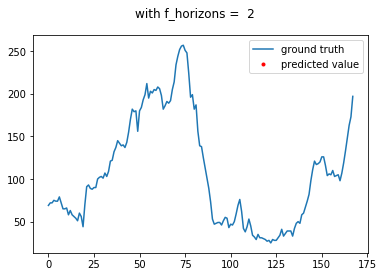

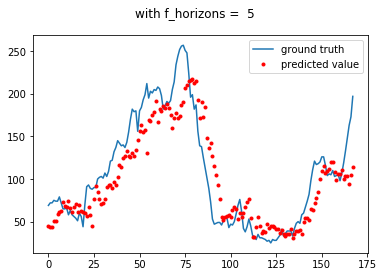

In [14]:
for i in range(len(Losses)):
    
    y_test = np.squeeze(y_tests[i])
    y_pred = np.squeeze(y_preds[i])
    
    fig, ax=plt.subplots(1, 1)
    
    x = range(len(y_test))
    
    f_horizon = f_horizons[i]
    fig.suptitle('with f_horizons =  %i' %(f_horizon));
      
    # p = plt.subplot(num)
    ax.plot(x, y_test, label="ground truth")
    ax.plot(x, y_pred, 'r.', label="predicted value")
    ax.legend()

## 2. 多变量预测

### 2.1 Introduce data

In [4]:
#  use all 210 features
all_features = bj_aq_stations_merged.dtypes.index
features = all_features

# use all selected features for input
input_features = features
# just use pm2.5, pm15 and O3 for output
output_features = [i for i in features if "PM2.5" in i or "PM10" in i or "O3" in i]

print("There are %d features in the input and %d features in the output." %(len(input_features), len(output_features)))

There are 210 features in the input and 105 features in the output.


In [5]:
df = bj_aq_stations_merged[features]
df = df.reset_index()
df = df.drop(columns=["format_time"])

In [6]:
# 缺失值处理，缺失值处理当前尽在 .ipynb 中生效，在 .py 文件中不生效
df.fillna(0, inplace=True)
# df.fillna(method="ffill", inplace=True)
df.isnull().values.any()

False

In [7]:
df.head()

,tiantan_aq_PM2.5,tiantan_aq_PM10,tiantan_aq_NO2,tiantan_aq_CO,tiantan_aq_O3,tiantan_aq_SO2,qianmen_aq_PM2.5,qianmen_aq_PM10,qianmen_aq_NO2,qianmen_aq_CO,...,wanshouxigong_aq_NO2,wanshouxigong_aq_CO,wanshouxigong_aq_O3,wanshouxigong_aq_SO2,yizhuang_aq_PM2.5,yizhuang_aq_PM10,yizhuang_aq_NO2,yizhuang_aq_CO,yizhuang_aq_O3,yizhuang_aq_SO2
0,357.0,449.0,116.0,6.2,2.0,4.0,436.0,0.0,157.0,6.8,...,140.0,0.6,7.0,5.0,278.0,362.0,117.0,5.7,6.0,2.0
1,351.0,467.0,109.0,6.4,2.0,5.0,443.0,0.0,161.0,7.2,...,139.0,6.1,6.0,5.0,298.0,382.0,117.0,5.8,6.0,3.0
2,346.0,451.0,101.0,6.6,2.0,4.0,429.0,0.0,153.0,7.3,...,138.0,6.5,6.0,4.0,306.0,393.0,116.0,6.1,6.0,2.0
3,339.0,447.0,98.0,6.6,2.0,4.0,448.0,0.0,166.0,7.5,...,133.0,6.9,7.0,5.0,306.0,387.0,118.0,6.3,6.0,3.0
4,345.0,471.0,101.0,6.9,2.0,4.0,452.0,0.0,161.0,7.4,...,126.0,6.6,7.0,5.0,315.0,408.0,111.0,6.4,7.0,3.0


### 2.2 Preprocessing

In [8]:
## Split into train and test - I used the last 1 month data as test, but it's up to you to decide the ratio
df_train = df.iloc[:(-31*24), :].copy()
df_test = df.iloc[-31*24:, :].copy()

## take out the useful columns for modeling
X_train = df_train.loc[:, input_features].values.copy()
X_test = df_test.loc[:, input_features].values.copy()

y_train = df_train[output_features].values.copy()
y_test = df_test[output_features].values.copy()

In [9]:
print("number of training data to be used, features")
print(X_train.shape, y_train.shape)
print("number of testing data to be used, features")
print(X_test.shape, y_test.shape)

number of training data to be used, features
(9554, 210) (9554, 105)
number of testing data to be used, features
(744, 210) (744, 105)


In [10]:
## z-score transform x
for i in range(X_train.shape[1]):
    temp_mean = X_train[:, i].mean()
    temp_std = X_train[:, i].std()
    X_train[:, i] = (X_train[:, i] - temp_mean) / temp_std
    X_test[:, i] = (X_test[:, i] - temp_mean) / temp_std
    
## z-score transform y
y_mean = y_train.mean()
y_std = y_train.std()
y_train = (y_train - y_mean) / y_std
y_test = (y_test - y_mean) / y_std

In [11]:
print("the mean and std of y are : ", y_mean, y_std)

the mean and std of y are :  68.2575116879492 74.19725419716897


### 2.3 Train and predict

In [12]:
f_horizon = 48
X_test, y_test = generate_test_samples(X_test, y_test, num_periods=168, f_horizon=48)

In [13]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(9554, 210) (9554, 105) (528, 168, 210) (528, 168, 105)


In [37]:
losses, y_pred = rnn_model(X_train, y_train, X_test, y_test, cell="BasicRNNCell", 
          learning_rate=0.001, epochs=2000, print_every=100, 
          inputs=210, outputs=105, hidden=100, num_periods=168, f_horizon=48)

MSE on 0 th epoch : 769762
MSE on 100 th epoch : 345886
MSE on 200 th epoch : 214260
MSE on 300 th epoch : 188132
MSE on 400 th epoch : 171194
MSE on 500 th epoch : 126191
MSE on 600 th epoch : 124141
MSE on 700 th epoch : 110288
MSE on 800 th epoch : 100258
MSE on 900 th epoch : 104437
MSE on 1000 th epoch : 106033
MSE on 1100 th epoch : 104965
MSE on 1200 th epoch : 88303
MSE on 1300 th epoch : 88729
MSE on 1400 th epoch : 97819
MSE on 1500 th epoch : 79682
MSE on 1600 th epoch : 98605
MSE on 1700 th epoch : 83363
MSE on 1800 th epoch : 72509
MSE on 1900 th epoch : 78188


In [38]:
# y_pred are predicted values on the X_test
print(y_pred.shape, y_test.shape)

(528, 168, 105) (528, 168, 105)


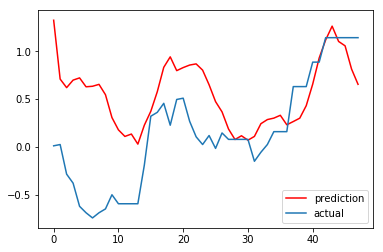

In [39]:
# Example 
# the first 120 are droped because we care about the last 48 elements
plt.plot(y_pred[0,120:,1], 'r', label='prediction');
plt.plot(y_test[0,120:,1], label='actual');
plt.legend();

## 2.3 Eveluation

In [40]:
y_pred_use = y_pred[:,120:,:]
y_test_use = y_test[:,120:,:]

In [41]:
aver_smapes, smapes_of_features = SMAPE_on_dataset(y_test_use, y_pred_use, output_features, y_mean, y_std, forecast_duration=24)

In [42]:
aver_smapes

0.806140878612778

In [43]:
smapes_of_features

{'aotizhongxin_aq_O3': 0.9989793357348606,
 'aotizhongxin_aq_PM10': 0.7101016197526694,
 'aotizhongxin_aq_PM2.5': 0.888329957164959,
 'badaling_aq_O3': 0.8125880393190351,
 'badaling_aq_PM10': 0.697619286686077,
 'badaling_aq_PM2.5': 0.9378210907095103,
 'beibuxinqu_aq_O3': 0.9889159294047374,
 'beibuxinqu_aq_PM10': 0.6633013373686526,
 'beibuxinqu_aq_PM2.5': 0.874672882495367,
 'daxing_aq_O3': 0.9333295871314399,
 'daxing_aq_PM10': 0.6816330205755198,
 'daxing_aq_PM2.5': 0.8580283279575963,
 'dingling_aq_O3': 0.5558481984883861,
 'dingling_aq_PM10': 0.6795116112024605,
 'dingling_aq_PM2.5': 0.9795668010429964,
 'donggaocun_aq_O3': 0.660277632451799,
 'donggaocun_aq_PM10': 0.6205018387376086,
 'donggaocun_aq_PM2.5': 0.8353021806481752,
 'dongsi_aq_O3': 0.8936476754238156,
 'dongsi_aq_PM10': 0.6382845447232629,
 'dongsi_aq_PM2.5': 0.8482696870392291,
 'dongsihuan_aq_O3': 1.150429925155687,
 'dongsihuan_aq_PM10': 0.8032115542280663,
 'dongsihuan_aq_PM2.5': 0.8708697040840185,
 'fangshan_

# ChangeLog
- 0419 
    - 实现了多变量的 lstm 模型，验证集上的 SMAPE 为 0.8 左右 

- 使用`lstm`对时间序列进行预测，原理如 Figure 1
    - 当向后预测的时间差很小的时候（比如1h），即对应图中 W(t) 预测 W(t+1)，效果很好，如1.1节末尾图。
    - 当尝试增大向后预测的时间间隔时（比如比赛中要求的48h），即对应图中 W(t) 预测 W(t+48)，模型的预测效果变得很差。
- 我理解这里边的原因
    - 当时间差很小的时候（比如1h），新一时刻的预测是基于之前所有的完整信息
    - 而当时间差很大时（比如48h），预测新一时刻的值只能止于两天之前的数据，这肯定是不能准确的
- 所以我的问题是
    - 这样的模型本身是不是不合理的，因为在预测 W(t+48) 时，只用到了 W(t) 及之前的信息，而没有用到 W(t+1)～W(t+47) 的信息
    - 是不是像 Figure 2 一样的 `attention model` 在原理上更合适一些，或者说这两种模型都不合适，应该用另外某种模型

![](http://p3rz3gu1u.bkt.clouddn.com/2018-04-14-lstm_predict_aq.png)
<caption><center> **Figure 1**: lstm model</center></caption>

![](http://p3rz3gu1u.bkt.clouddn.com/2018-04-15-attn_model.png)
<caption><center> **Figure 2**: attention model</center></caption>